In [97]:
import time

import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import angular_separation
from astropy.io import fits
import astropy.units as u
import camb

%matplotlib inline

In [98]:
def l_res(nside):
    """Calculate the multipole moment l resolution for a given nside."""
    return int(np.pi / hp.nside2resol(nside=nside))

In [99]:
# not vectorized, so slow

# def c_theta(map, nside, angles):
#     T = map.mean()
#     l, b = hp.pix2ang(
#         nside=nside, ipix=np.arange(hp.nside2npix(nside=nside)))
#     theta = np.pi / 2 - b
#     phi = l
#     C_theta = []
#     n = len(map)
#     for alpha in angles:
#         sum = 0
#         n_pairs = 0
#         for i in range(n):
#             t1 = map[i]
#             for j in range(n):
#                 # Can check that your angle works by comparing to 
#                 # cos(theta) = \hat(n1)\cdot\hat(n2), 
#                 # where n1 and n2 can be obtained from pix2vec command.
#                 sep = angular_separation(phi[i], theta[i], phi[j], theta[j])
#                 if np.abs(sep-alpha) < 0.05:
#                     t2 = map[j]
#                     sum += (t1 - T)*(t2 - T)
#                     n_pairs += 1
#         if sum:
#             C_theta.append(sum/n_pairs)
#         else:
#             C_theta.append(0)
            
#     return np.array(C_theta)

In [100]:
def c_theta(map, nside, angles, tol=0.05, chunk=512, nest=True) -> np.ndarray:
    """
    C(theta) estimator.

    Parameters:
    -----------
        - map: 1D healpy map (match 'nest' ordering)
        - nside: healpy nside
        - angles: array of theta (radians)
        - tol: half-width window around each angle (radians)
        - chunk: number of rows processed per block to control memory

    Returns:
    -----------
        - C_theta: array of C(theta) values at input angles
    """
    T = map.mean()
    delta = map - T
    npix = hp.nside2npix(nside)
    # unit vectors for all pixels (shape (N,3))
    vecs = np.vstack(hp.pix2vec(nside, np.arange(npix), nest=nest)).T

    # precompute cos bounds for each angle
    # want pairs with |sep - angle| < tol --> angle - tol < sep < angle + tol
    # cos is decreasing function, so upper/lower are flipped
    lower = np.cos(np.clip(angles + tol, 0.0, np.pi))
    upper = np.cos(np.clip(np.maximum(angles - tol, 0.0), 0.0, np.pi))

    C_acc = np.zeros(len(angles))
    n_pairs = np.zeros(len(angles))

    # process in chunks to avoid building the full N x N matrix
    for i0 in range(0, npix, chunk):
        i1 = min(i0 + chunk, npix)
        v_chunk = vecs[i0:i1]                # (chunk,3)
        # cos of separations between chunk and all pixels -> (chunk, N)
        cossep = v_chunk.dot(vecs.T)
        # product of deltaT for pairs in this block -> (chunk, N)
        prod = delta[i0:i1, None] * delta[None, :]

        for k, (lo, up) in enumerate(zip(lower, upper)):
            mask = (cossep >= lo) & (cossep <= up)
            if mask.any():
                C_acc[k] += (prod * mask).sum()
                n_pairs[k] += int(mask.sum())

    C_theta = np.zeros_like(C_acc)
    nonzero = n_pairs > 0
    C_theta[nonzero] = C_acc[nonzero] / n_pairs[nonzero]
    return C_theta

In [140]:
NSIDE = 128
# Set up a new set of parameters for CAMB
# The defaults give one massive neutrino and helium set using BBN consistency
lmax = l_res(nside=NSIDE)
pars = camb.set_params(
    H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06, As=2e-9, 
    ns=0.965, halofit_version='mead', lmax=lmax
)

# calculate results for these parameters
results = camb.get_results(pars)
# get dictionary of CAMB power spectra
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK', 
                                       raw_cl=True)

In [141]:
ANGLES = np.linspace(0, np.pi, num=50)
totCL = powers['total']*1e-6    # convert from muK^2 to mK^2
ls = np.arange(totCL.shape[0])
ls = ls[ls >= 2]
cl = totCL[ls][:,0]
pls = np.array([np.polynomial.legendre.Legendre.basis(l)(np.cos(ANGLES)) for l in ls])
weights = (2*ls + 1) / (4*np.pi)

C_theta_thry = np.sum(
    (weights * cl)[:, None] * pls, axis=0)

sigma_Ctheta = np.sqrt(np.sum(
    ((weights * cl)[:, None]**2) * (2.0 / (2 * ls + 1))[:, None] * pls**2, axis=0))

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2009-12-16T00:00:00' /file creation date (YYYY-MM-DDThh:mm:ss UT)    
TELESCOP= 'WMAP     '          / Wilkinson Microwave Anisotropy Probe           
OBJECT  = 'ALL-SKY '           / Portion of sky given                           
EQUINOX =               2000.0 / Equinox of coordinates                         
COMMENT   This file contains the WMAP Internal Linear Combination (ILC) map     
COMMENT   based on the first 7 years of observations.                           
REFERENC= 'WMAP Explanatory 

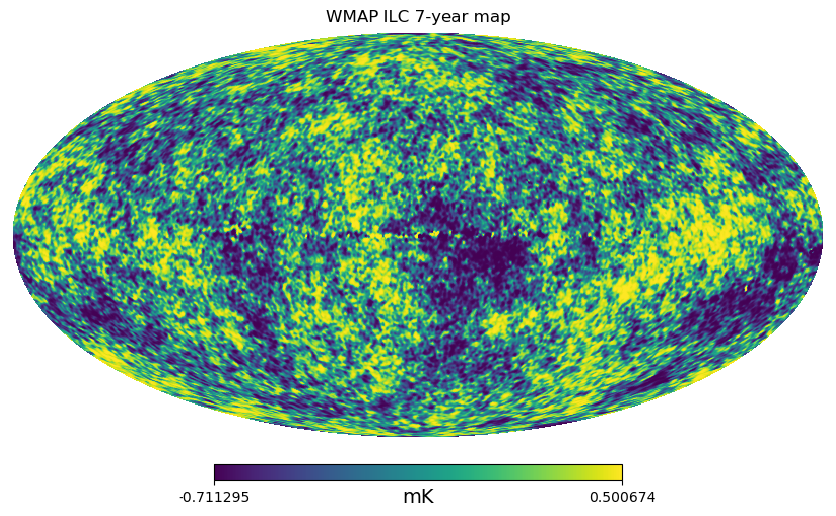

In [ ]:
file = 'maps/wmap_ilc_7yr_v4.fits'
ilc = hp.read_map(file, nest=True)
hdulist = fits.open(file)
data = hdulist[0]
hp.mollview(ilc, title='WMAP ILC 7-year map',
            unit='mK', norm='hist', nest=True)
plt.savefig('plots/wmap_ilc_y7.pdf')
data.header

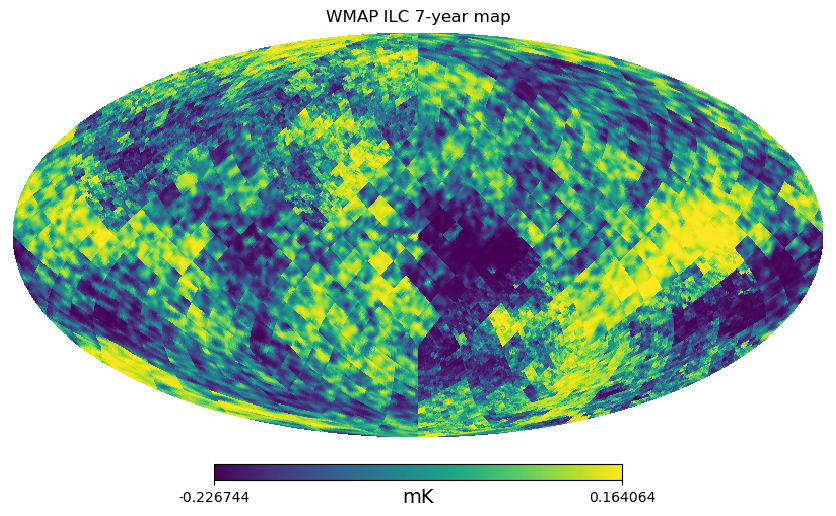

In [ ]:
ilc = hp.pixelfunc.ud_grade(map_in=ilc, nside_out=NSIDE)
hp.mollview(ilc, title='WMAP ILC 7-year map',
            unit='mK', norm='hist', nest=True)
plt.savefig(f'plots/wmap_ilc_y7_nside{NSIDE}.pdf')

In [ ]:
start = time.time()
c_theta_ilc = c_theta(ilc, NSIDE, ANGLES)
t = time.time() - start
print(f"{t:.2f}s")

3047.15s


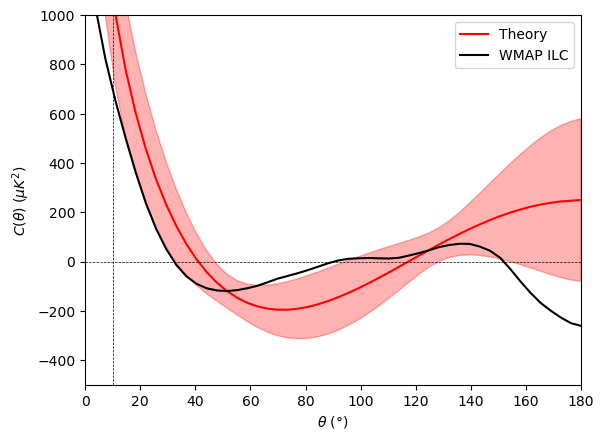

In [ ]:
fig, axs = plt.subplots(1, 1)
axs.plot(np.degrees(ANGLES), C_theta_thry*1e6, color='r', label='Theory')
axs.fill_between(np.degrees(ANGLES), C_theta_thry*1e6 -
                 sigma_Ctheta*1e6, C_theta_thry*1e6 + sigma_Ctheta*1e6, 
                 color='r', alpha=0.3)
axs.plot(np.degrees(ANGLES), c_theta_ilc*1e6, color='k', label='WMAP ILC')
axs.set_xlabel(r'$\theta$ ($\degree$)')
axs.set_xlim(0, 180)
axs.set_ylabel(r'$C(\theta)$ ($\mu K^2$)')
axs.set_ylim(-500, 1000)
axs.axhline(0, color='k', lw=0.5, ls='--')
axs.axvline(10, color='k', lw=0.5, ls='--')
axs.legend()
plt.savefig('plots/ilc_ctheta.pdf')
plt.show()

SIMPLE  =                    T /FITS format                                     
BITPIX  =                   16 /Dummy primary header                            
NAXIS   =                    0 /No data is associated with this header          
EXTEND  =                    T /Extensions may (will!) be present               
RESOLUTN=                    9 /Resolution Index                                
PIXTYPE = 'HEALPIX '           /Pixel algorigthm                                
ORDERING= 'NESTED  '           /Ordering scheme                                 
NSIDE   =                  512 /Resolution Parameter                            
FIRSTPIX=                    0 /First pixel (0 based)                           
LASTPIX =              3145727 /Last pixel (0 based)                            
COMMENT This file contains a WMAP Intensity (I) Res 9 skymap for the            
COMMENT frequency band indicated by the FREQ keyword.                           
COMMENT Seven years of data 

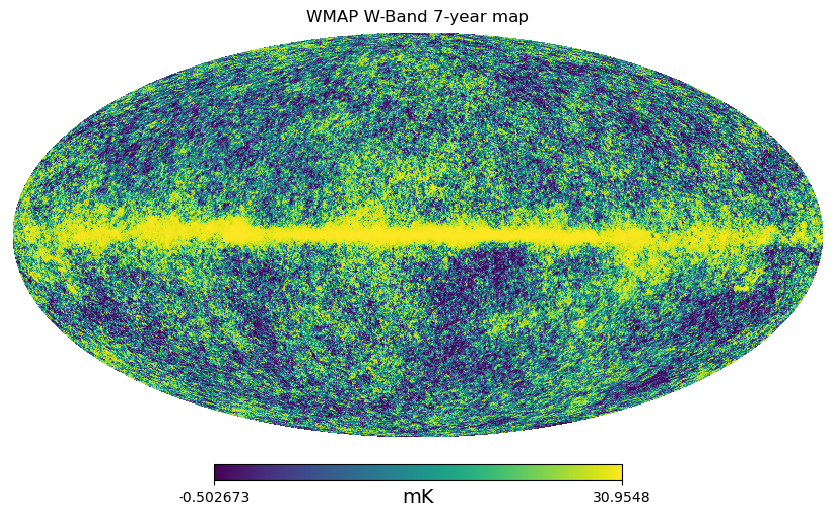

In [ ]:
file = 'maps/wmap_band_imap_r9_7yr_W_v4.fits'
wmap = hp.read_map(file, nest=True)
hdulist = fits.open(file)
data = hdulist[0]
hp.mollview(wmap, title='WMAP W-Band 7-year map',
            unit='mK', norm='hist', nest=True)
plt.savefig('plots/wmap_wband_y7.pdf')
data.header

SIMPLE  =                    T /FITS format                                     
BITPIX  =                   16 /Dummy primary header                            
NAXIS   =                    0 /No data is associated with this header          
EXTEND  =                    T /Extensions may (will!) be present               
RESOLUTN=                    9 /Resolution Index                                
PIXTYPE = 'HEALPIX '           /Pixel algorithm                                 
ORDERING= 'NESTED  '           /Ordering scheme                                 
NSIDE   =                  512 /Resolution Parameter                            
FIRSTPIX=                    0 /First pixel (0 based)                           
LASTPIX =              3145727 /Last pixel (0 based)                            
COMMENT Mask of Galactic plane and Magellanic cloud regions                     
COMMENT used in making the WMAP 7-year point source catalog                     
DATE    = '2009-10-05T00:00:

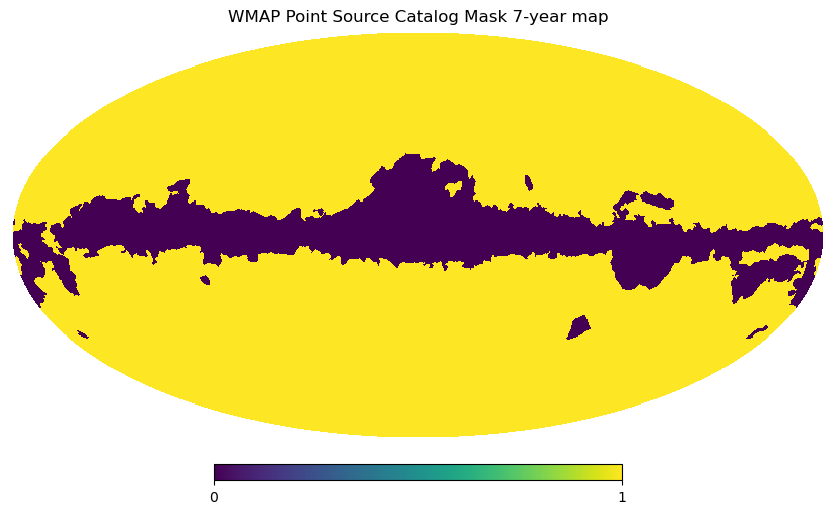

In [ ]:
file = 'maps/wmap_point_source_catalog_mask_r9_7yr_v4.fits'
mask = hp.read_map(file, nest=True)
hdulist = fits.open(file)
data = hdulist[0]
hp.mollview(mask, title='WMAP Point Source Catalog Mask 7-year map',
            norm='hist', nest=True)
data.header

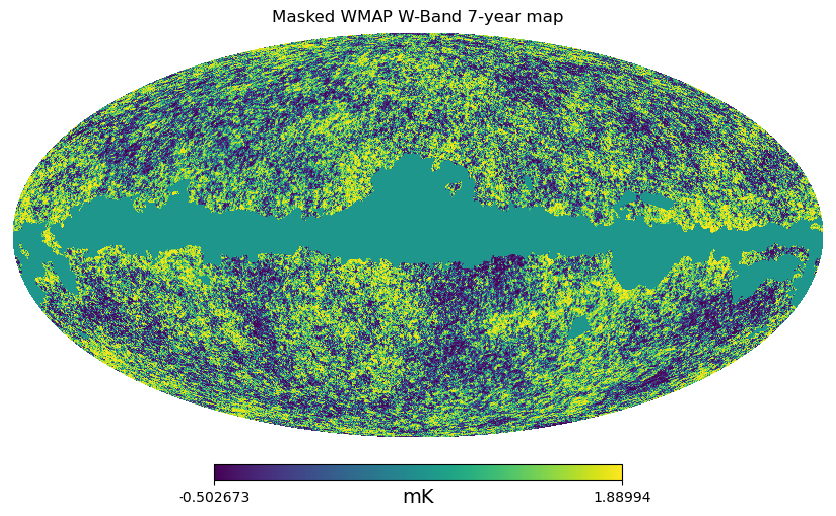

In [ ]:
wmap = wmap * mask
hp.mollview(wmap, title='Masked WMAP W-Band 7-year map',
            unit='mK', norm='hist', nest=True)
plt.savefig('plots/wmap_wband_y7_masked.pdf')

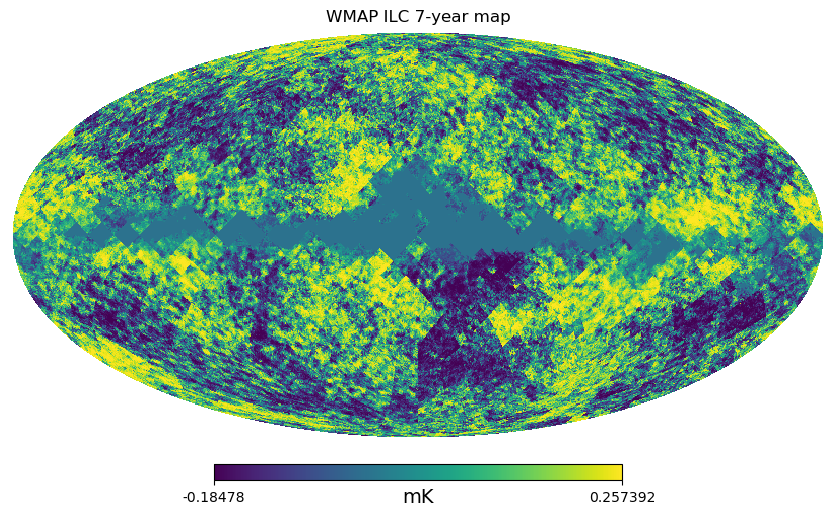

In [ ]:
wmap = hp.pixelfunc.ud_grade(map_in=wmap, nside_out=NSIDE)
hp.mollview(wmap, title='WMAP ILC 7-year map',
            unit='mK', norm='hist', nest=True)
plt.savefig('plots/wmap_wband_y7_nside64.pdf')

In [ ]:
start = time.time()
c_theta_wmap = c_theta(wmap, NSIDE, ANGLES)
t = time.time() - start
print(f"{t:.2f}s")

2927.55s


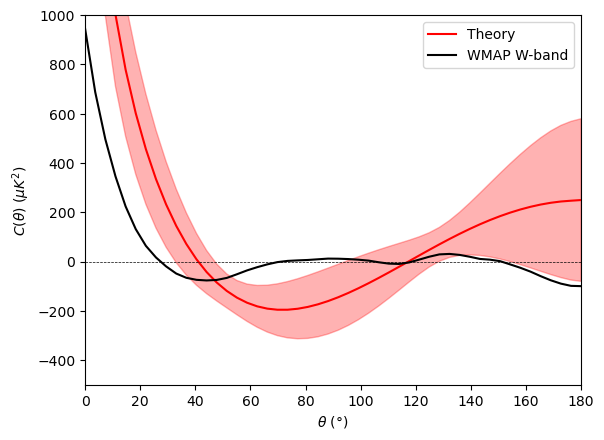

In [ ]:
fig, axs = plt.subplots(1, 1)
axs.plot(np.degrees(ANGLES), C_theta_thry*1e6, color='r', label='Theory')
axs.fill_between(np.degrees(ANGLES), C_theta_thry*1e6 -
                 sigma_Ctheta*1e6, C_theta_thry*1e6 + sigma_Ctheta*1e6,
                 color='r', alpha=0.3)
axs.plot(np.degrees(ANGLES), c_theta_wmap*1e6, color='k', label='WMAP W-band')
axs.set_xlabel(r'$\theta$ ($\degree$)')
axs.set_xlim(0, 180)
axs.set_ylabel(r'$C(\theta)$ ($\mu K^2$)')
axs.set_ylim(-500, 1000)
axs.axhline(0, color='k', lw=0.5, ls='--')
axs.legend()
plt.savefig('plots/wmap_ctheta.pdf')
plt.show()

# Planck

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   32 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2018-04-20T13:01:36' / file creation date (YYYY-MM-DDThh:mm:ss UT)   

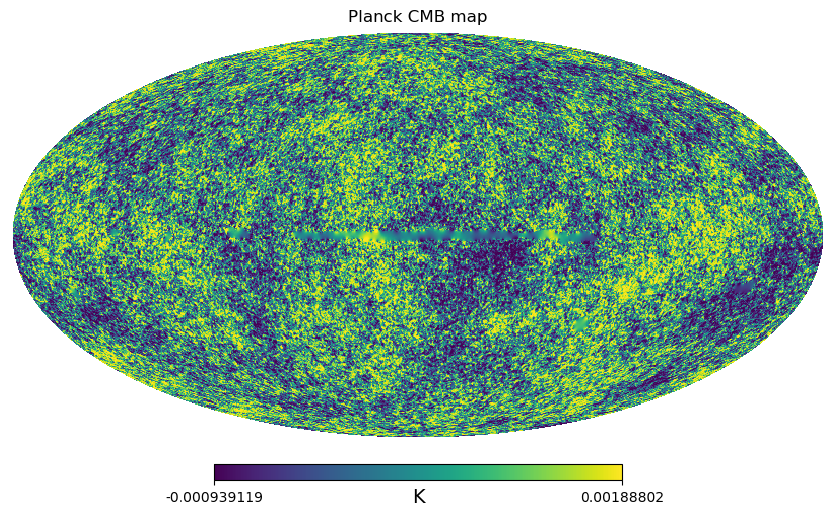

In [ ]:
file = 'maps/COM_CMB_IQU-smica_2048_R3.00_full.fits'
planck = hp.read_map(file, nest=True)
hdulist = fits.open(file)
data = hdulist[0]
hp.mollview(planck, title='Planck CMB map',
            unit='K', norm='hist', nest=True)
plt.savefig('plots/planck_cmb_map.pdf')
data.header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   32 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2018-04-18T10:40:59' / file creation date (YYYY-MM-DDThh:mm:ss UT)   

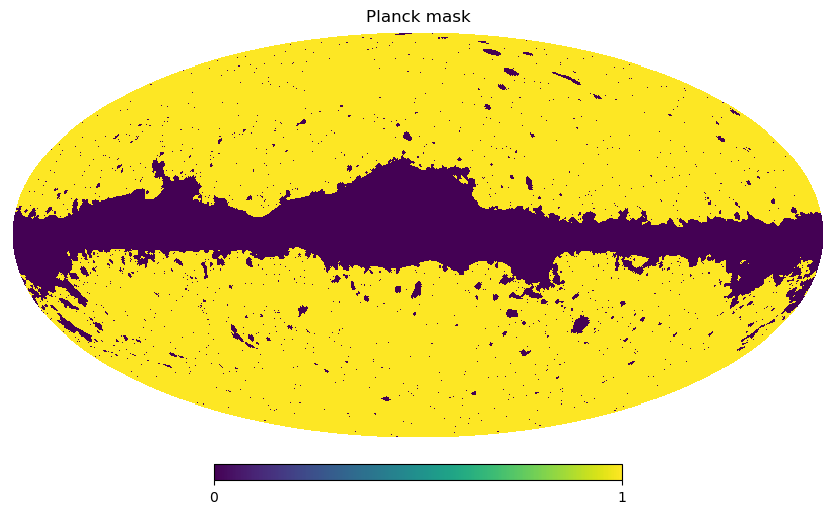

In [ ]:
file = 'maps/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits'
mask = hp.read_map(file, nest=True)
hdulist = fits.open(file)
data = hdulist[0]
hp.mollview(mask, title='Planck mask',norm='hist', nest=True)
data.header

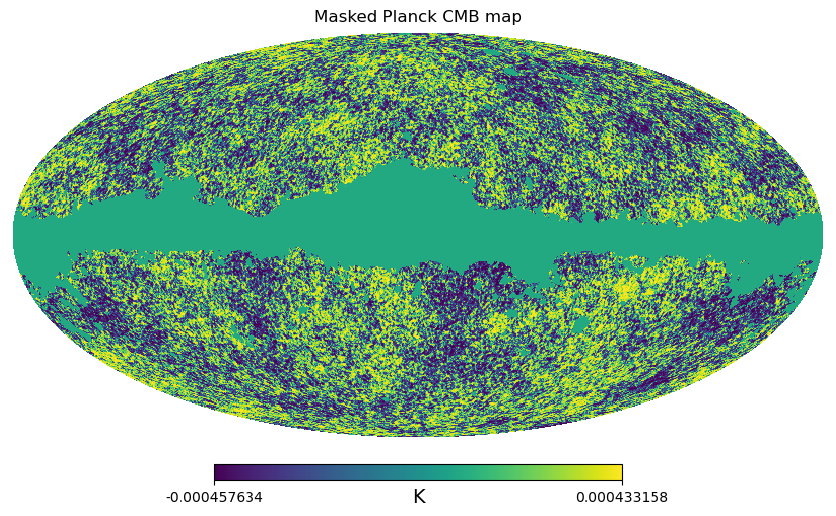

In [ ]:
planck = planck * mask
hp.mollview(planck, title='Masked Planck CMB map',
            unit='K', norm='hist', nest=True)
plt.savefig('plots/planck_cmb_map_masked.pdf')

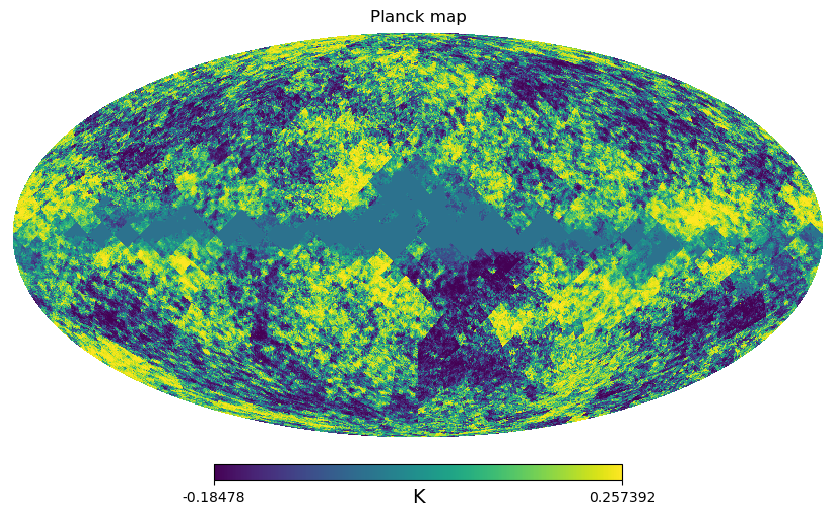

In [ ]:
planck = hp.pixelfunc.ud_grade(map_in=planck, nside_out=NSIDE)
hp.mollview(wmap, title='Planck map',
            unit='K', norm='hist', nest=True)

In [ ]:
start = time.time()
c_theta_planck = c_theta(planck, NSIDE, ANGLES)
t = time.time() - start
print(f"{t:.2f}s")

2919.53s


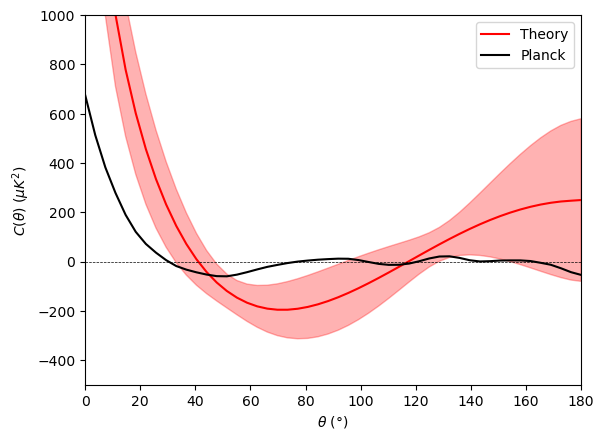

In [ ]:
fig, axs = plt.subplots(1, 1)
axs.plot(np.degrees(ANGLES), C_theta_thry*1e6, color='r', label='Theory')
axs.fill_between(np.degrees(ANGLES), C_theta_thry*1e6 -
                 sigma_Ctheta*1e6, C_theta_thry*1e6 + sigma_Ctheta*1e6,
                 color='r', alpha=0.3)
axs.plot(np.degrees(ANGLES), c_theta_planck*1e12, color='k', label='Planck')
axs.set_xlabel(r'$\theta$ ($\degree$)')
axs.set_xlim(0, 180)
axs.set_ylabel(r'$C(\theta)$ ($\mu K^2$)')
axs.set_ylim(-500, 1000)
axs.axhline(0, color='k', lw=0.5, ls='--')
axs.legend()
plt.savefig('plots/planck_ctheta.pdf')
plt.show()